In [1]:
import pandas as pd
import numpy as np
import replicaEVSE.load_curve as sim
import replicaEVSE.datautils as simdu
import matplotlib.pyplot as plt
import os
import joblib
from tqdm import tqdm
from glob import glob
# import dask.dataframe as dd
import pandas as dd
import datetime as dt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

datadir = '../../data/'

 1) read in the loads and charges
 2) compute the peak load
 3) compute the fraction of charging events as a function of charger type

In [9]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=-1)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

/home/matthew.wilde@RMI.local/mambaforge/envs/py311/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42387 instead
  warnings.warn(


In [2]:
seg_list = ['Personal Sedan',
 'Personal Crossover',
 'Personal Truck/SUV',
 'Commercial Sedan',
 'Commercial Crossover',
 'Commercial Truck/SUV']

# read in the loads and charges

In [3]:
charge_files = glob(datadir + 'loads_charges/charges_2*_2023-06-06.parquet')
charges_list = []
for cfile in charge_files:
    charges = dd.read_parquet(cfile)
    charges_list.append(charges)
charges = dd.concat(charges_list)

loads_files = glob(datadir + 'loads_charges/loads_2*_2023-06-06.parquet')
loads_list = []
for lfile in loads_files:
    loads = dd.read_parquet(lfile)
    loads_list.append(loads)
loads = dd.concat(loads_list)


In [4]:
charges.columns, loads.columns

(Index(['person_id', 'charge_id', 'charge_type', 'activity_id', 'simulation_id',
        'charger_power_kW', 'charge_energy_used_kWh',
        'charge_opportunity_remaining_kWh', 'weekday', 'year', 'segment',
        'work_frac', 'multiunit_frac'],
       dtype='object'),
 Index(['person_id', 'load_segment_id', 'charge_id', 'charge_type',
        'window_start_time', 'window_end_time', 'load_kW', 'weekday', 'year',
        'segment', 'work_frac', 'multiunit_frac'],
       dtype='object'))

In [5]:
reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

In [6]:
charges = charges[charges['charger_power_kW'] > 0]

In [8]:
max_load = loads.groupby(['year','hour',])['load_kW'].sum()

In [9]:
loadsmall = loads[['charge_id', 'hour', 'load_kW']]
loadsmall = loadsmall[loadsmall['load_kW'] > 0] # remove 0 loads
all = loadsmall.merge(charges, on='charge_id', how='left')

In [10]:
all.columns

Index(['charge_id', 'hour', 'load_kW', 'person_id', 'charge_type',
       'activity_id', 'simulation_id', 'charger_power_kW',
       'charge_energy_used_kWh', 'charge_opportunity_remaining_kWh', 'weekday',
       'year', 'segment', 'work_frac', 'multiunit_frac'],
      dtype='object')

### Find the max load per year

In [11]:
max_load = all.groupby(['year','hour',])['load_kW'].sum()

In [13]:
df = all.copy()
df['location'] = df.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
df['location'] = df['location'].where(df['location'].isin(keep_values), 'work')

In [14]:
load_by_loc = df.groupby(['year','location', 'hour', ])['load_kW'].sum()
load_by_loc.groupby(['year', 'location']).max()/ max_load.groupby('year').max()

year  location          
2023  multi_family_home     0.022060
      public                0.336536
      single_family_home    0.757803
      work                  0.020253
2025  multi_family_home     0.028784
      public                0.327923
      single_family_home    0.754423
      work                  0.025634
Name: load_kW, dtype: float64

In [17]:
workfrac = np.linspace(0.2, 0.5, 4)
multiunitfrac = np.linspace(0.2, 6.0, 4)

year  location           hour
2023  multi_family_home  0       5258.637228
                         1       3299.762551
                         2       1895.919228
                         3       1305.077669
                         4        979.952819
                                    ...     
2025  work               19      3242.448025
                         20      2612.420696
                         21      1830.308641
                         22      1239.343013
                         23       895.451558
Name: load_kW, Length: 192, dtype: float64

In [15]:
max_load = all.groupby(['year','hour',])['load_kW'].sum()

In [16]:
max_load.groupby('year').max()

year
2023    361003.917919
2025    655162.344965
Name: load_kW, dtype: float64

year  location          
2023  public                0.614619
      single_family_home    0.340299
      work                  0.026459
      multi_family_home     0.018623
2025  public                0.614632
      single_family_home    0.340308
      work                  0.026474
      multi_family_home     0.018586
2030  public                0.614739
      single_family_home    0.340365
      work                  0.026352
      multi_family_home     0.018543
2035  public                0.614698
      single_family_home    0.340328
      work                  0.026403
      multi_family_home     0.018572
dtype: float64


location
public                0.614672
single_family_home    0.340325
work                  0.026422
multi_family_home     0.018581
Name: count, dtype: float64

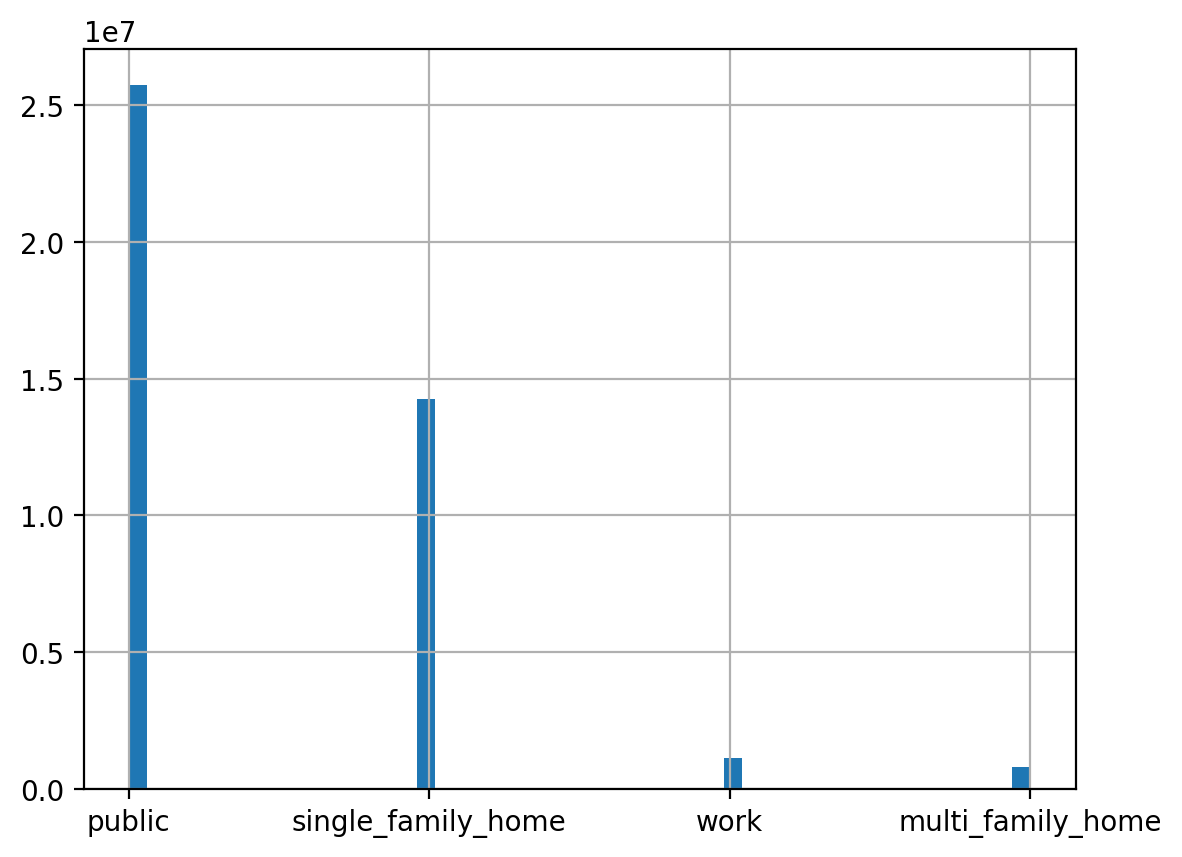

In [50]:
charges['location'] = charges.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
charges['location'] = charges['location'].where(charges['location'].isin(keep_values), 'work')

charges_year = charges.groupby(['year'])['location'].value_counts()
charges_year_tot = charges.groupby(['year'])['location'].count()

print(charges_year/charges_year_tot)

charges[charges['charger_power_kW'] > 0]['location'].hist(bins=50)
charges[charges['charger_power_kW'] > 0]['location'].value_counts()/len(charges[charges['charger_power_kW'] > 0])

In [67]:
all['location'] = all.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
all['location'] = all['location'].where(all['location'].isin(keep_values), 'work')


In [64]:
def load_frac_by_loc(df, day='thursday', hour=19):
    df_thu = df.loc[(df.weekday == day)& (df['hour'] == hour)].copy()
    df_peak_load = df_thu.groupby(['year',])['load_kW'].sum()
    total_load = df_peak_load.load_kW.sum()
    df_peak_load['load_frac_by_loc'] = df_peak_load.load_kW/total_load
    df_peak_load[['location', 'load_frac_by_loc']]
    print("peak load: ", total_load)
    return df_peak_load[['location', 'load_frac_by_loc']]


load_frac_by_loc(all, day='thursday', hour=19)

KeyError: 'location'

In [ ]:
all['location'] = all.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
all['location'] = all['location'].where(all['location'].isin(keep_values), 'work')

charges_year = charges.groupby(['year'])['location']['load_kW'].sum()
charges_year_tot = charges.groupby(['year'])['location'].count()

print(charges_year/charges_year_tot)

charges[charges['charger_power_kW'] > 0]['location'].hist(bins=50)
charges[charges['charger_power_kW'] > 0]['location'].value_counts()/len(charges[charges['charger_power_kW'] > 0])